In [12]:
#Implementation of trb in rocketpy with notes about data: from where it was taken, if it is reliable and if not from where we want to take it in the future.

In [36]:
#Imports
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank, MonteCarlo
from math import exp
from datetime import datetime, timedelta
from rocketpy.simulation import FlightDataExporter
import datetime
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticNoseCone,
    StochasticParachute,
    StochasticRailButtons,
    StochasticRocket,
    StochasticSolidMotor,
    StochasticTail,
    StochasticTrapezoidalFins,
)

In [24]:
#Env
#Standard atmosphere - no wind for stable outcomes

# Environment ensemble for monte carlo
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type="Ensemble", file="GEFS")
#Toruń Kod od Antka
# env = Environment(latitude=52.94401645806493, longitude=18.63890735729045)
# # 52.94401645806493, 18.63890735729045 toruń poligon <----
# moment = datetime.date.fromisoformat('2025-07-27')
# env.set_date((moment.year, moment.month, moment.day, 14))  # godizna w UTC (tam byla 15:51 GMT+2)
# env.set_atmospheric_model(type="Windy", file="GFS")
# env.max_expected_height = 10000


#Far-out
# tomorrow = datetime.now() + timedelta(days=1)
# env = Environment(
#     date=tomorrow,  
#     latitude=35.35,
#     longitude=-117.81, # Far-out not precise
# )
# env.set_elevation("Open-Elevation")
# env.set_atmospheric_model(type="forecast", file="GFS")
# env.max_expected_height = 10000
# env.plots.atmospheric_model()

#env.info()

In [25]:
#Change of mass as a time function: linear approximation using two linear functions

def mass_change(time):
    if time < 5:
        return 4.2
    else:
        return 0.62

In [26]:
liq_mix = Fluid(name="mix", density=1133.8)
gas_mix = Fluid(name="mix", density=1.8)

tank_shape = CylindricalTank(radius=0.093, height=1.08, spherical_caps=False)

mix_tank = MassFlowRateBasedTank(   
    name="mix_tank",
    geometry=tank_shape,
    flux_time=11.2,
    initial_liquid_mass=25,
    initial_gas_mass=0.0001,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=lambda t: mass_change(t),
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=lambda t: 0.0001 / 11.2 * exp(-0.25 * t),
    liquid=liq_mix,
    gas=gas_mix,


)

Nozzle Details
Nozzle Radius: 0.036 m

Motor Details
Total Burning Time: 14.4 s
Total Propellant Mass: 25.000 kg
Structural Mass Ratio: 0.097
Average Propellant Exhaust Velocity: 2028.507 m/s
Average Thrust: 2240.935 N
Maximum Thrust: 4575.401 N at 1.089 s after ignition.
Total Impulse: 32269.462 Ns



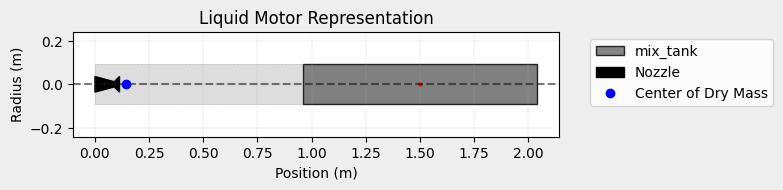

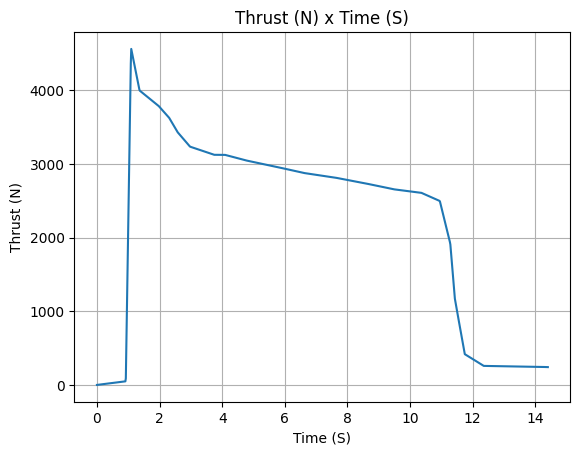

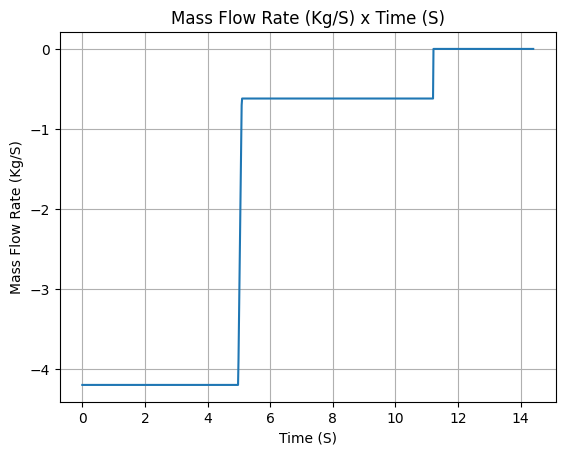

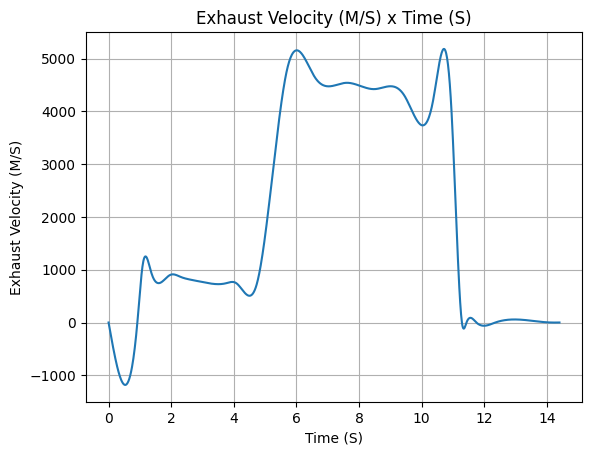

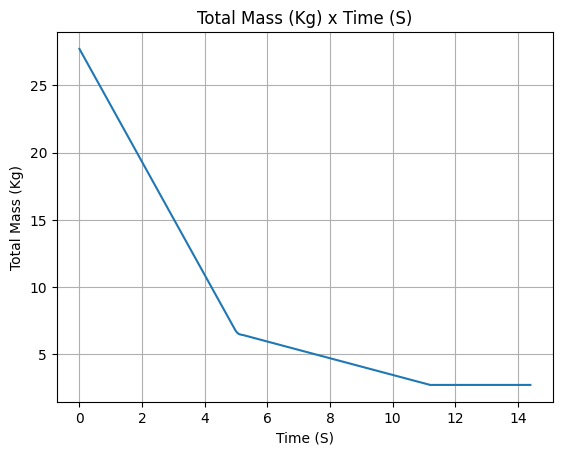

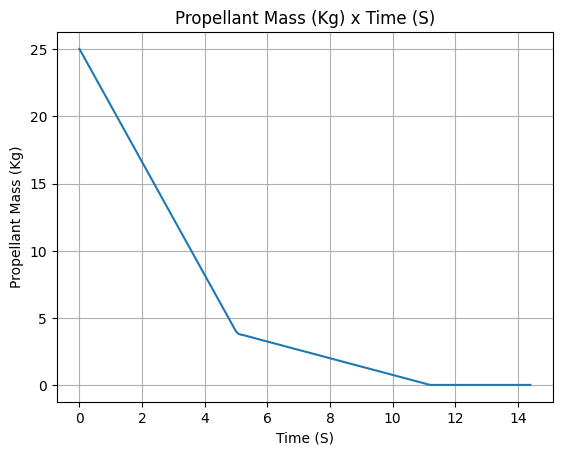

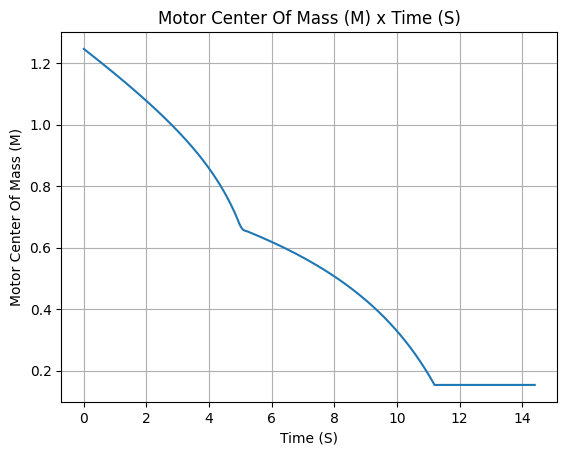

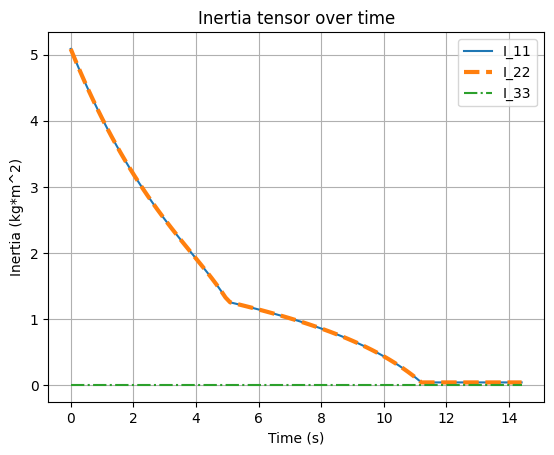

In [27]:
# Motor
# Thrust source from openrocket .eng file, dry mass it the mass of a motor: 2.7
z4000 = LiquidMotor(
    thrust_source="..\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=mix_tank, position=1.5) #From nozzle to center of the tank


z4000.all_info()

In [28]:
# Rocket 
trb = Rocket(
    radius=0.1,
    mass=58.367, #All mass - engine mass and fuel
    inertia=(98.203, 98.203, 0.29184), #Rough estimations, the correct values should be calculated from CAD
    power_off_drag="..\\data\\powerondrag.csv", #This should be taken from ansys or some other cfd simulation, here I use data from openrocket
    power_on_drag='..\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, #from openrocket
    coordinate_system_orientation="nose_to_tail", #Same as in openrocket
)
trb.add_motor(z4000, position=4.49)
#trb.all_info()

In [29]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2, #Just some value, not accurate
    lower_button_position=4, #Just some value, not accurate
    angular_position=45, #Just some value, not accurate
)
#Parachutes cd_s just guessed so that the velocity at the landing is similar to openrocket
# main = trb.add_parachute(
#     name="main",
#     cd_s=15, #Matched to openrocket impact velocity
#     trigger=1000,      # ejection altitude in meters
#     sampling_rate=105,
#     lag=0,
#     noise=(0, 8.3, 0.5),
#     radius=2.25, #From openrocket
#     height=2.25, #This should tell how flattened the parachute is, here it's perfect semi-sphere
#     porosity=0.0432,
# )

# drogue = trb.add_parachute(
#     name="drogue",
#     cd_s=1.45, #Matched to openrocket flight time
#     trigger="apogee",  # ejection at apogee
#     sampling_rate=105,
#     lag=1.5,
#     noise=(0, 8.3, 0.5),
#     radius=0.76, #From openrocket
#     height=0.76, #same as above
#     porosity=0.0432,
# )

main = trb.add_parachute(
    name='main',
    cd_s=0.8,
    radius=2.25,
    trigger=1000,
)
drogue = trb.add_parachute(
    name='drouge',
    cd_s=0.55,
    radius=0.85,
    trigger="apogee",
)
# trb.draw()
# trb.plots.drag_curves()

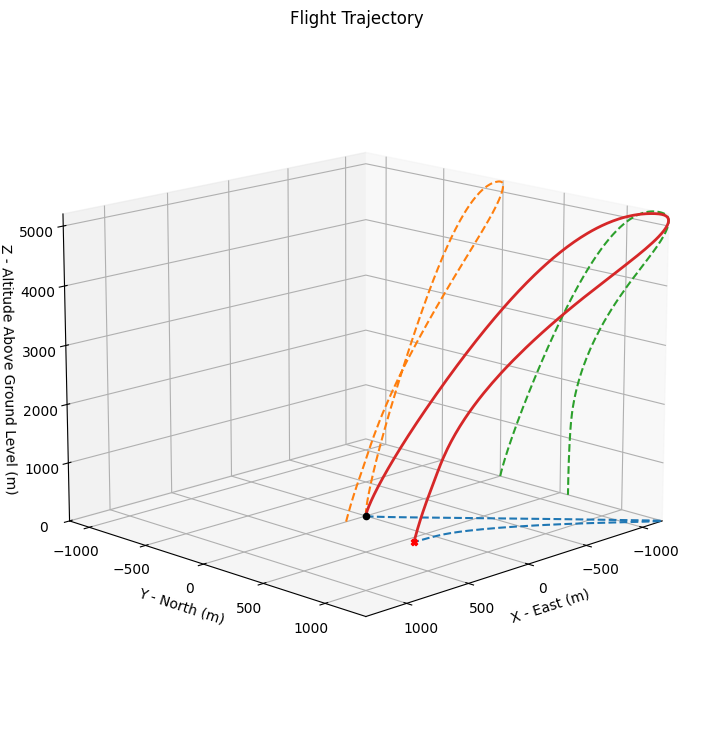

In [31]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=10, inclination=85, heading=0
    )

#trb.all_info()
#test_flight.all_info()
test_flight.plots.trajectory_3d()
#test_flight.plots.linear_kinematics_data()
#test_flight.prints.impact_conditions()



In [33]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                113
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.3897
	longitude                -8.288964
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [34]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[np.float64(5.400538078830686), np.float64(5.731734482391829), np.float64(6.669429590560155), np.float64(6.91554773608746), np.float64(6.320433998775257)]


In [35]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           10

Stochastic Attributes:
	heading               53.00000 ± 2.00000 (normal)
	inclination           84.70000 ± 1.00000 (normal)


In [38]:
test_dispersion = MonteCarlo(
    filename="../monte_carlo/mc_class_example",
    environment=stochastic_env,
    rocket=trb,
    flight=stochastic_flight,
)

The following input file was imported: ..\monte_carlo\mc_class_example.inputs.txt
A total of 0 simulations results were loaded from the following output file: ..\monte_carlo\mc_class_example.outputs.txt

The following error file was imported: ..\monte_carlo\mc_class_example.errors.txt                                        


c:\Users\krikb\Desktop\Pulpit\agh_space_systems\simulations\venv\Lib\site-packages\rocketpy\simulation\monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


In [42]:
test_dispersion.simulate(
    number_of_simulations=10,
    append=False,
    include_function_data=False,
    parallel=True,
)

Starting Monte Carlo analysis                 
Running Monte Carlo simulation with 16 workers.


AttributeError: module 'dill' has no attribute '_dill'

In [ ]:
#Exporting data from rocketpy
exporter = FlightDataExporter(test_flight)
exporter.export_data(
    "trb_flight_data.csv",
    "z", #Altitude
)

Columns found: Index(['# Time (s)', ' Z (m)'], dtype='object')
Plot saved as altitude_plot.png


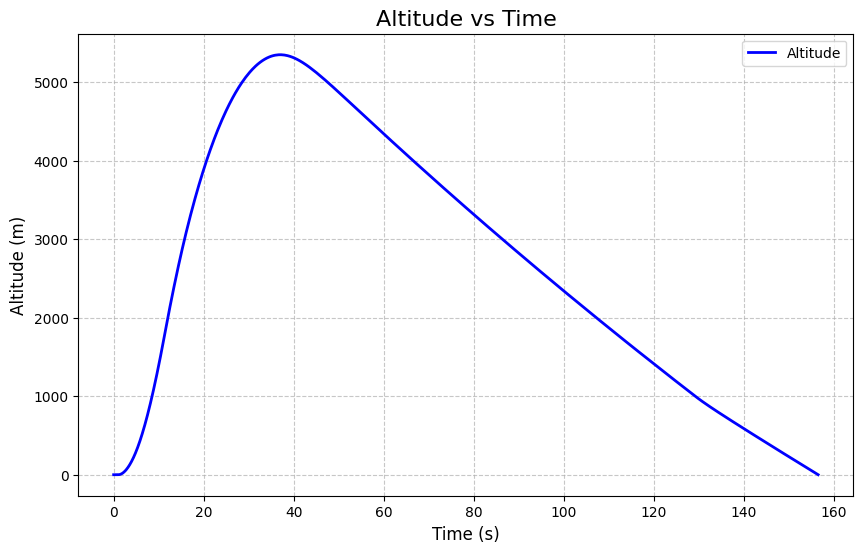

In [ ]:
#Plotting custom plots
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the CSV file
# Replace 'trb_flight_data.csv' with the path to your file
csv_filename = 'trb_flight_data.csv'
df = pd.read_csv(csv_filename)

# 2. Inspect the column names (Optional: helps verify data is loaded correctly)
print("Columns found:", df.columns)

# 3. Plotting
plt.figure(figsize=(10, 6))

# NOTE: Change '# Time (s)' and ' Z (m)' below to match the exact headers in your CSV
x_column = '# Time (s)'
y_column = ' Z (m)'

plt.plot(df[x_column], df[y_column], label='Altitude', color='blue', linewidth=2)

# Labeling the graph
plt.title('Altitude vs Time', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Altitude (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 4. Save and Show the plot
plt.savefig('altitude_plot.png')
print("Plot saved as altitude_plot.png")